In [9]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

sidr_data = genfromtxt('sveidr_age2_sim.csv', delimiter=',') #in the form of [t,S,V,I,D,R]

torch.manual_seed(1234)

In [10]:
sidr_data.shape

(13, 100)

In [11]:
%%time

PATH = 'svidr_norm_simple' 

class DINN(nn.Module):
    def __init__(self, t, S1_data, V1_data, E1_data, I1_data, D1_data, R1_data, 
                 S2_data, V2_data, E2_data, I2_data, D2_data, R2_data): #[t,S,V,E,I,D,R]
        super(DINN, self).__init__()
        self.N = 3.5e7 #population size
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S1 = torch.tensor(S1_data)
        self.V1 = torch.tensor(V1_data)
        self.E1 = torch.tensor(E1_data)
        self.I1 = torch.tensor(I1_data)
        self.D1 = torch.tensor(D1_data)
        self.R1 = torch.tensor(R1_data)
        self.S2 = torch.tensor(S2_data)
        self.V2 = torch.tensor(V2_data)
        self.E2 = torch.tensor(E2_data)
        self.I2 = torch.tensor(I2_data)
        self.D2 = torch.tensor(D2_data)
        self.R2 = torch.tensor(R2_data)

        self.losses = []
        self.save = 2 #which file to save to

        self.alpha_tilda = torch.nn.Parameter(torch.rand(1,requires_grad=True))
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.sigma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.lbda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.rho_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.M00_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.M01_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.M11_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        
        #find values for normalization
        self.S1_max, self.S2_max = max(self.S1), max(self.S2)
        self.V1_max, self.V2_max = max(self.V1), max(self.V2)
        self.E1_max, self.E2_max = max(self.E1), max(self.E2)
        self.I1_max, self.I2_max = max(self.I1), max(self.I2)
        self.D1_max, self.D2_max = max(self.D1), max(self.D2)
        self.R1_max, self.R2_max = max(self.R1), max(self.R2)
        self.S1_min, self.S2_min = min(self.S1), min(self.S2)
        self.V1_min, self.V2_min = min(self.V1), min(self.V2)
        self.E1_min, self.E2_min = min(self.E1), min(self.E2)
        self.I1_min, self.I2_min = min(self.I1), min(self.I2)
        self.D1_min, self.D2_min = min(self.D1), min(self.D2)
        self.R1_min, self.R2_min = min(self.R1), min(self.R2)

        #normalize
        self.S1_hat = (self.S1 - self.S1_min) / (self.S1_max - self.S1_min)
        self.V1_hat = (self.V1 - self.V1_min) / (self.V1_max - self.V1_min)
        self.E1_hat = (self.E1 - self.E1_min) / (self.E1_max - self.E1_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.D1_hat = (self.D1 - self.D1_min) / (self.D1_max - self.D1_min)
        self.R1_hat = (self.R1 - self.R1_min) / (self.R1_max - self.R1_min)

        self.S2_hat = (self.S2 - self.S2_min) / (self.S2_max - self.S2_min)
        self.V2_hat = (self.V2 - self.V2_min) / (self.V2_max - self.V2_min)
        self.E2_hat = (self.E2 - self.E2_min) / (self.E2_max - self.E2_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.D2_hat = (self.D2 - self.D2_min) / (self.D2_max - self.D2_min)
        self.R2_hat = (self.R2 - self.R2_min) / (self.R2_max - self.R2_min)

        #matrices (x12 for S,V,E,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 12)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 12)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 12)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 12)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 12)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 12)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 12)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 12)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 12)); self.m9[:, 8] = 1
        self.m10 = torch.zeros((len(self.t), 12)); self.m10[:, 9] = 1
        self.m11 = torch.zeros((len(self.t), 12)); self.m11[:, 10] = 1
        self.m12 = torch.zeros((len(self.t), 12)); self.m12[:, 11] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.alpha_tilda, self.beta_tilda, self.gamma_tilda, self.sigma_tilda, self.lbda_tilda, self.rho_tilda, 
                                 self.M00_tilda, self.M01_tilda, self.M11_tilda]))


    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda) * 3.5e-3

    @property
    def beta(self):
        return torch.tanh(self.beta_tilda) *0.02 + 0.3
    
    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda) *0.02 + 0.18
    
    @property
    def sigma(self):
        return torch.tanh(self.sigma_tilda) *0.02 + 0.05

    @property
    def lbda(self):
        return torch.tanh(self.lbda_tilda) *0.02 + 0.06
    
    @property
    def rho(self):
        return torch.tanh(self.rho_tilda)*0.02 + 0.1

    @property
    def M00(self):
        return torch.tanh(self.M00_tilda)*0.1 + 20.7

    @property
    def M01(self):
        return torch.tanh(self.M01_tilda)*0.1 + 6.3  
    
    @property
    def M11(self):
        return torch.tanh(self.M11_tilda)*0.1 + 10.4
    

    #nets
    class Net_sidr(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 12) #outputs S, V, E, I, D, R

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr
            
    def net_f(self, t_batch):
        sidr_hat = self.net_sidr(t_batch)

        S1_hat, V1_hat, E1_hat, I1_hat, D1_hat, R1_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3], sidr_hat[:,4], sidr_hat[:,5]
        S2_hat, V2_hat, E2_hat, I2_hat, D2_hat, R2_hat = sidr_hat[:,6], sidr_hat[:,7], sidr_hat[:,8], sidr_hat[:,9], sidr_hat[:,10], sidr_hat[:,11]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m7, retain_graph=True)
        S2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #V_t
        sidr_hat.backward(self.m2, retain_graph=True)
        V1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m8, retain_graph=True)
        V2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #E_t
        sidr_hat.backward(self.m3, retain_graph=True)
        E1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m9, retain_graph=True)
        E2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m4, retain_graph=True)
        I1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m10, retain_graph=True)
        I2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m5, retain_graph=True)
        D1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m11, retain_graph=True)
        D2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m6, retain_graph=True)
        R1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m12, retain_graph=True)
        R2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S1 = self.S1_min + (self.S1_max - self.S1_min) * S1_hat
        V1 = self.V1_min + (self.V1_max - self.V1_min) * V1_hat
        E1 = self.E1_min + (self.E1_max - self.E1_min) * E1_hat
        I1 = self.I1_min + (self.I1_max - self.I1_min) * I1_hat
        D1 = self.D1_min + (self.D1_max - self.D1_min) * D1_hat      
        R1 = self.R1_min + (self.R1_max - self.R1_min) * R1_hat

        S2 = self.S2_min + (self.S2_max - self.S2_min) * S2_hat
        V2 = self.V2_min + (self.V2_max - self.V2_min) * V2_hat
        E2 = self.E2_min + (self.E2_max - self.E2_min) * E2_hat
        I2 = self.I2_min + (self.I2_max - self.I2_min) * I2_hat
        D2 = self.D2_min + (self.D2_max - self.D2_min) * D2_hat      
        R2 = self.R2_min + (self.R2_max - self.R2_min) * R2_hat

        f1_hat = S1_hat_t - (-self.beta/self.N * S1 * (self.M00*I1+self.M01*I2) - self.alpha * S1)  / (self.S1_max - self.S1_min)
        f2_hat = V1_hat_t - (self.alpha * S1 - self.sigma * self.beta/self.N * V1 * (self.M00*I1+self.M01*I2))  / (self.V1_max - self.V1_min)
        f3_hat = E1_hat_t - (self.beta/self.N * S1 * (self.M00*I1+self.M01*I2) + self.sigma * self.beta/self.N * V1 * (self.M00*I1+self.M01*I2) - self.gamma * E1) / (self.E1_max - self.E1_min)
        f4_hat = I1_hat_t - (self.gamma * E1 - self.lbda * I1 - self.rho * I1 ) / (self.I1_max - self.I1_min)
        f5_hat = D1_hat_t - (self.lbda * I1) / (self.D1_max - self.D1_min)
        f6_hat = R1_hat_t - (self.rho * I1 ) / (self.R1_max - self.R1_min)
        
        f7_hat = S2_hat_t - (-self.beta/self.N * S2 * (self.M01*I1+self.M11*I2) - self.alpha * S2)  / (self.S2_max - self.S2_min)
        f8_hat = V2_hat_t - (self.alpha * S2 - self.sigma * self.beta/self.N * V2 * (self.M01*I1+self.M11*I2))  / (self.V2_max - self.V2_min)
        f9_hat = E2_hat_t - (self.beta/self.N * S2 * (self.M01*I1+self.M11*I2) + self.sigma * self.beta/self.N * V2 * (self.M01*I1+self.M11*I2) - self.gamma * E2) / (self.E2_max - self.E2_min)
        f10_hat = I2_hat_t - (self.gamma * E2 - self.lbda * I2 - self.rho * I2 ) / (self.I2_max - self.I2_min)
        f11_hat = D2_hat_t - (self.lbda * I2) / (self.D2_max - self.D2_min)
        f12_hat = R2_hat_t - (self.rho * I2 ) / (self.R2_max - self.R2_min)

        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, f8_hat, f9_hat, f10_hat, f11_hat, f12_hat, S1_hat, V1_hat, E1_hat, I1_hat, D1_hat, R1_hat, S2_hat, V2_hat, E2_hat, I2_hat, D2_hat, R2_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        self.losses = checkpoint['losses']

      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S1_pred_list, V1_pred_list, E1_pred_list, I1_pred_list, D1_pred_list, R1_pred_list = [], [], [], [], [], []
        S2_pred_list, V2_pred_list, E2_pred_list, I2_pred_list, D2_pred_list, R2_pred_list = [], [], [], [], [], []
        
        f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, S1_pred, V1_pred, E1_pred, I1_pred, D1_pred, R1_pred, S2_pred, V2_pred, E2_pred, I2_pred, D2_pred, R2_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S1_pred_list.append(self.S1_min + (self.S1_max - self.S1_min) * S1_pred)
        V1_pred_list.append(self.V1_min + (self.V1_max - self.V1_min) * V1_pred) 
        E1_pred_list.append(self.E1_min + (self.E1_max - self.E1_min) * E1_pred) 
        I1_pred_list.append(self.I1_min + (self.I1_max - self.I1_min) * I1_pred)
        D1_pred_list.append(self.D1_min + (self.D1_max - self.D1_min) * D1_pred)
        R1_pred_list.append(self.R1_min + (self.R1_max - self.R1_min) * R1_pred)

        S2_pred_list.append(self.S2_min + (self.S2_max - self.S2_min) * S2_pred)
        V2_pred_list.append(self.V2_min + (self.V2_max - self.V2_min) * V2_pred) 
        E2_pred_list.append(self.E2_min + (self.E2_max - self.E2_min) * E2_pred) 
        I2_pred_list.append(self.I2_min + (self.I2_max - self.I2_min) * I2_pred)
        D2_pred_list.append(self.D2_min + (self.D2_max - self.D2_min) * D2_pred)
        R2_pred_list.append(self.R2_min + (self.R2_max - self.R2_min) * R2_pred)

        train_day = 90

        loss = (torch.mean(torch.square(self.S1_hat[:train_day] - S1_pred[:train_day]))+ 
                torch.mean(torch.square(self.V1_hat[:train_day] - V1_pred[:train_day]))+
                torch.mean(torch.square(self.E1_hat[:train_day] - E1_pred[:train_day]))+
                torch.mean(torch.square(self.I1_hat[:train_day] - I1_pred[:train_day]))+
                torch.mean(torch.square(self.D1_hat[:train_day] - D1_pred[:train_day]))+
                torch.mean(torch.square(self.R1_hat[:train_day] - R1_pred[:train_day]))+
                torch.mean(torch.square(self.S2_hat[:train_day] - S2_pred[:train_day]))+ 
                torch.mean(torch.square(self.V2_hat[:train_day] - V2_pred[:train_day]))+
                torch.mean(torch.square(self.E2_hat[:train_day] - E2_pred[:train_day]))+
                torch.mean(torch.square(self.I2_hat[:train_day] - I2_pred[:train_day]))+
                torch.mean(torch.square(self.D2_hat[:train_day] - D2_pred[:train_day]))+
                torch.mean(torch.square(self.R2_hat[:train_day] - R2_pred[:train_day]))+
                torch.mean(torch.square(f1[:train_day]))+
                torch.mean(torch.square(f2[:train_day]))+
                torch.mean(torch.square(f3[:train_day]))+
                torch.mean(torch.square(f4[:train_day]))+
                torch.mean(torch.square(f5[:train_day]))+
                torch.mean(torch.square(f6[:train_day]))+
                torch.mean(torch.square(f7[:train_day]))+
                torch.mean(torch.square(f8[:train_day]))+
                torch.mean(torch.square(f9[:train_day]))+
                torch.mean(torch.square(f10[:train_day]))+
                torch.mean(torch.square(f11[:train_day]))+
                torch.mean(torch.square(f12[:train_day]))
                ) 

        #loss.backward(retain_graph=True)
        loss.backward()
        self.optimizer.step()
        self.scheduler.step(loss) 
        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)
          print('alpha: (goal 3.5e-4 ', self.alpha)
          print('beta: (goal 0.3 ', self.beta)
          print('gamma: (goal 0.18 ', self.gamma)
          print('sigma: (goal 0.05 ', self.sigma)
          print('lbda: (goal 0.06 ', self.lbda)
          print('rho: (goal 0.1 ', self.rho)
          print('M00: (goal 20.7 ', self.M00)
          print('M01: (goal 6.3 ', self.M01)
          print('M11: (goal 10.4 ', self.M11)
          print('#################################') 

      return S1_pred_list, V1_pred_list, E1_pred_list, I1_pred_list, D1_pred_list, R1_pred_list, S2_pred_list, V2_pred_list, E2_pred_list, I2_pred_list, D2_pred_list, R2_pred_list

Wall time: 0 ns


In [12]:
%%time

dinn = DINN(sidr_data[0], sidr_data[1], sidr_data[2], sidr_data[3], sidr_data[4], sidr_data[5], 
            sidr_data[6], sidr_data[7], sidr_data[8], sidr_data[9], sidr_data[10], sidr_data[11], sidr_data[12]) #in the form of [t,S,V,E,I,D,R]

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

# scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, mode='min', factor=0.1, patience=1000, min_lr=1e-8, eps=1e-8)

dinn.scheduler = scheduler

nepochs = int(6e5)

S1_pred_list, V1_pred_list, E1_pred_list, I1_pred_list, D1_pred_list, R1_pred_list, S2_pred_list, V2_pred_list, E2_pred_list, I2_pred_list, D2_pred_list, R2_pred_list = dinn.train(nepochs) #train


starting training...


Epoch  0
alpha: (goal 3.5e-4  tensor([0.0001], grad_fn=<MulBackward0>)
beta: (goal 0.3  tensor([0.3076], grad_fn=<AddBackward0>)
gamma: (goal 0.18  tensor([0.1851], grad_fn=<AddBackward0>)
sigma: (goal 0.05  tensor([0.0570], grad_fn=<AddBackward0>)
lbda: (goal 0.06  tensor([0.0612], grad_fn=<AddBackward0>)
rho: (goal 0.1  tensor([0.1121], grad_fn=<AddBackward0>)
M00: (goal 20.7  tensor([20.7052], grad_fn=<AddBackward0>)
M01: (goal 6.3  tensor([6.3437], grad_fn=<AddBackward0>)
M11: (goal 10.4  tensor([10.4587], grad_fn=<AddBackward0>)
#################################

Epoch  1000
alpha: (goal 3.5e-4  tensor([7.7073e-05], grad_fn=<MulBackward0>)
beta: (goal 0.3  tensor([0.3075], grad_fn=<AddBackward0>)
gamma: (goal 0.18  tensor([0.1849], grad_fn=<AddBackward0>)
sigma: (goal 0.05  tensor([0.0568], grad_fn=<AddBackward0>)
lbda: (goal 0.06  tensor([0.0610], grad_fn=<AddBackward0>)
rho: (goal 0.1  tensor([0.1120], grad_fn=<AddBackward0>)
M00: (goal 20.7  tensor([20.7

total loss:  0.0003506257297759286


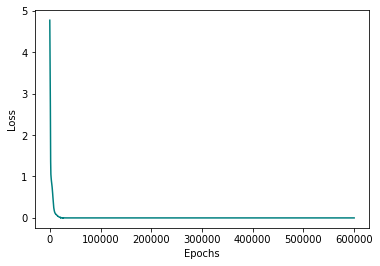

In [13]:
plt.plot(dinn.losses, color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')
print('total loss: ', dinn.losses[-1])

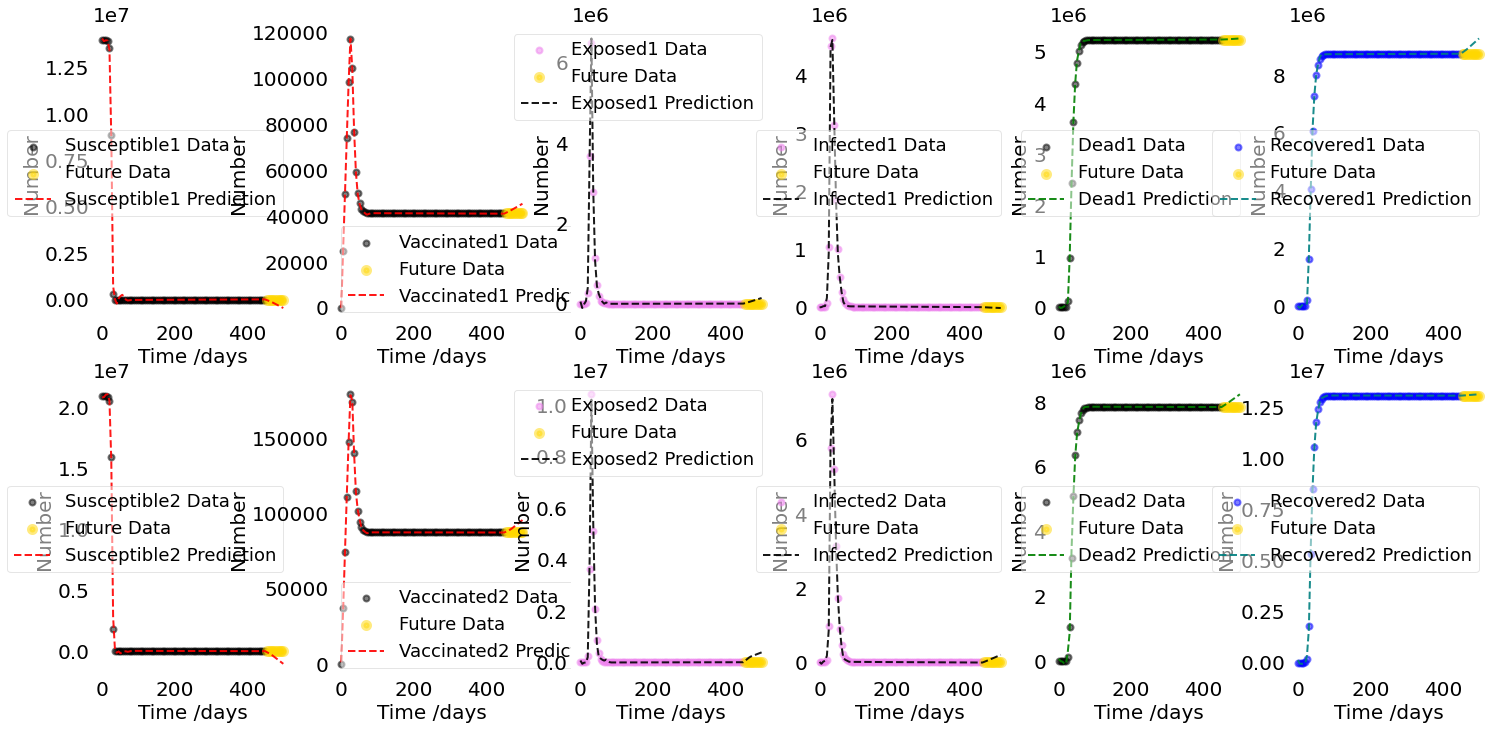

In [24]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

fig, ax = plt.subplots(2, 6, figsize = (25,12))

for i in range(2):
    for j in range(5):
        ax[i, j].set_facecolor('xkcd:white')


train_day = 90

ax[0, 0].scatter(sidr_data[0][:train_day], sidr_data[1][:train_day], c = 'black', alpha=0.5, lw=2, label='Susceptible1 Data')
ax[0, 0].scatter(sidr_data[0][train_day:], sidr_data[1][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 0].plot(sidr_data[0], S1_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Susceptible1 Prediction', linestyle='dashed')

ax[0, 1].scatter(sidr_data[0][:train_day], sidr_data[2][:train_day], c = 'black', alpha=0.5, lw=2, label='Vaccinated1 Data')
ax[0, 1].scatter(sidr_data[0][train_day:], sidr_data[2][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 1].plot(sidr_data[0], V1_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Vaccinated1 Prediction', linestyle='dashed')

ax[0, 2].scatter(sidr_data[0][:train_day], sidr_data[3][:train_day], c = 'violet', alpha=0.5, lw=2, label='Exposed1 Data')
ax[0, 2].scatter(sidr_data[0][train_day:], sidr_data[3][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 2].plot(sidr_data[0], E1_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Exposed1 Prediction', linestyle='dashed')

ax[0, 3].scatter(sidr_data[0][:train_day], sidr_data[4][:train_day], c = 'violet', alpha=0.5, lw=2, label='Infected1 Data')
ax[0, 3].scatter(sidr_data[0][train_day:], sidr_data[4][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 3].plot(sidr_data[0], I1_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Infected1 Prediction', linestyle='dashed')

ax[0, 4].scatter(sidr_data[0][:train_day], sidr_data[5][:train_day], c = 'black', alpha=0.5, lw=2, label='Dead1 Data')
ax[0, 4].scatter(sidr_data[0][train_day:], sidr_data[5][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 4].plot(sidr_data[0], D1_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Dead1 Prediction', linestyle='dashed')

ax[0, 5].scatter(sidr_data[0][:train_day], sidr_data[6][:train_day], c = 'blue', alpha=0.5, lw=2, label='Recovered1 Data')
ax[0, 5].scatter(sidr_data[0][train_day:], sidr_data[6][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 5].plot(sidr_data[0], R1_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Recovered1 Prediction', linestyle='dashed')

ax[1, 0].scatter(sidr_data[0][:train_day], sidr_data[7][:train_day], c = 'black', alpha=0.5, lw=2, label='Susceptible2 Data')
ax[1, 0].scatter(sidr_data[0][train_day:], sidr_data[7][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 0].plot(sidr_data[0], S2_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Susceptible2 Prediction', linestyle='dashed')

ax[1, 1].scatter(sidr_data[0][:train_day], sidr_data[8][:train_day], c = 'black', alpha=0.5, lw=2, label='Vaccinated2 Data')
ax[1, 1].scatter(sidr_data[0][train_day:], sidr_data[8][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 1].plot(sidr_data[0], V2_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Vaccinated2 Prediction', linestyle='dashed')

ax[1, 2].scatter(sidr_data[0][:train_day], sidr_data[9][:train_day], c = 'violet', alpha=0.5, lw=2, label='Exposed2 Data')
ax[1, 2].scatter(sidr_data[0][train_day:], sidr_data[9][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 2].plot(sidr_data[0], E2_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Exposed2 Prediction', linestyle='dashed')

ax[1, 3].scatter(sidr_data[0][:train_day], sidr_data[10][:train_day], c = 'violet', alpha=0.5, lw=2, label='Infected2 Data')
ax[1, 3].scatter(sidr_data[0][train_day:], sidr_data[10][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 3].plot(sidr_data[0], I2_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Infected2 Prediction', linestyle='dashed')

ax[1, 4].scatter(sidr_data[0][:train_day], sidr_data[11][:train_day], c = 'black', alpha=0.5, lw=2, label='Dead2 Data')
ax[1, 4].scatter(sidr_data[0][train_day:], sidr_data[11][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 4].plot(sidr_data[0], D2_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Dead2 Prediction', linestyle='dashed')

ax[1, 5].scatter(sidr_data[0][:train_day], sidr_data[12][:train_day], c = 'blue', alpha=0.5, lw=2, label='Recovered2 Data')
ax[1, 5].scatter(sidr_data[0][train_day:], sidr_data[12][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 5].plot(sidr_data[0], R2_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Recovered2 Prediction', linestyle='dashed')

for i in range(2):
    for j in range(6):
        ax[i, j].set_xlabel('Time /days',size = 20)
        ax[i, j].set_ylabel('Number',size = 20)
        ax[i, j].yaxis.set_tick_params(length=0)
        ax[i, j].xaxis.set_tick_params(length=0)
        legend = ax[i, j].legend(prop={'size':18})
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax[i, j].spines[spine].set_visible(False)
plt.savefig('age_output4_1.png')
plt.show()

alpha: (goal 3.5e-4  0.0003290419699624181
beta: (goal 0.3  0.30183544754981995
gamma: (goal 0.18  0.18552473187446594
sigma: (goal 0.05  0.04984227940440178
lbda: (goal 0.06  0.06014474853873253
rho: (goal 0.1  0.1116562932729721
M00: (goal 20.7  20.673494338989258
M01: (goal 6.3  6.321005344390869
M11: (goal 10.4  10.441582679748535
#################################


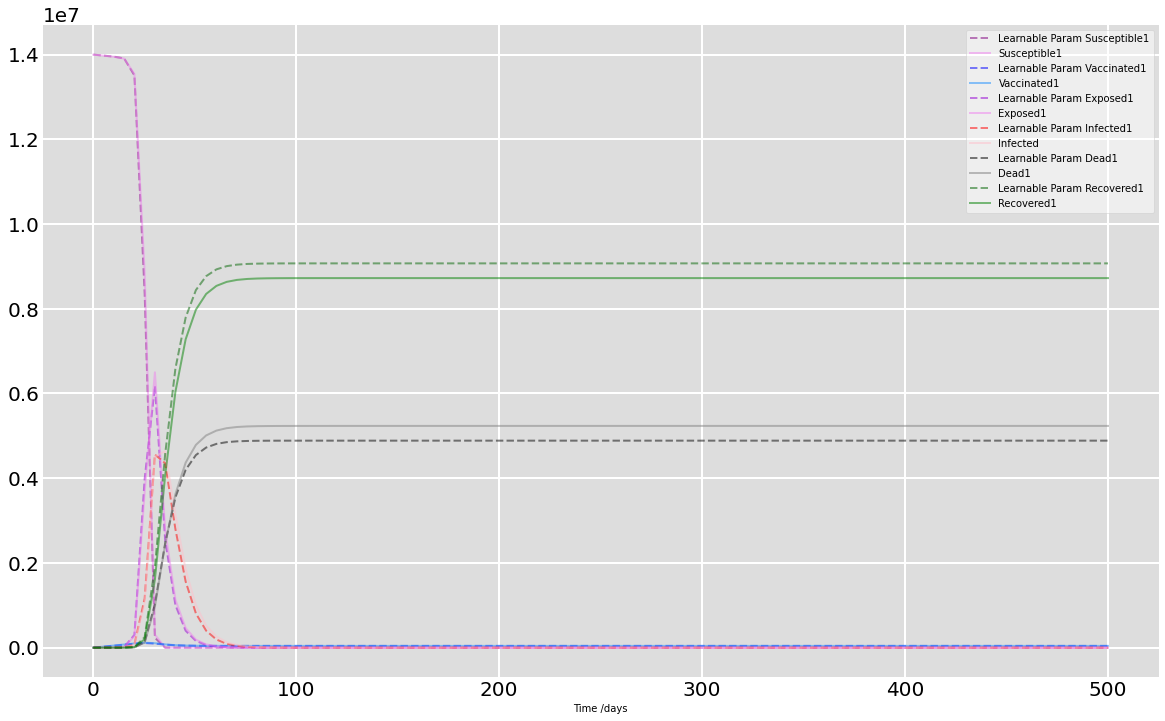

In [25]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions
N = 3.5e7

init0 = np.array([[N*0.4, N*0.6],
          [0, 0],
          [0, 0],
          [1, 1],
          [0, 0],
          [0, 0]])
# A grid of time points (in days)
t = np.linspace(0, 500, 100) 

#parameters
alpha = dinn.alpha.detach().numpy().item()
beta = dinn.beta.detach().numpy().item()
gamma = dinn.gamma.detach().numpy().item()
sigma = dinn.sigma.detach().numpy().item()
lbda = dinn.lbda.detach().numpy().item()
rho = dinn.rho.detach().numpy().item()
M00 = dinn.M00.detach().numpy().item()
M01 = dinn.M01.detach().numpy().item()
M11 = dinn.M11.detach().numpy().item()
print('alpha: (goal 3.5e-4 ', alpha)
print('beta: (goal 0.3 ', beta)
print('gamma: (goal 0.18 ', gamma)
print('sigma: (goal 0.05 ', sigma)
print('lbda: (goal 0.06 ', lbda)
print('rho: (goal 0.1 ', rho)
print('M00: (goal 20.7 ', M00)
print('M01: (goal 6.3 ', M01)
print('M11: (goal 10.4 ', M11)
print('#################################') 
M = np.array([[M00, M01],
              [M01, M11]])

# The SVEIDR model differential equations.
def deriv(y, t, age_num,  alpha, beta, gamma, sigma, lbda, rho, M):
    S, V, E, I, D, R = y[0:2], y[2:4], y[4:6], y[6:8], y[8:10], y[10:12]
    dSdt, dVdt, dEdt, dIdt, dDdt, dRdt = [], [], [], [], [], []

    for i in range(age_num):
        dSdt.append( - beta/N * S[i] * M[i, :].dot(I) - alpha * S[i] )
        dVdt.append( alpha * S[i] - sigma * beta/N * V[i] * M[i, :].dot(I) )
        dEdt.append( beta/N * S[i] * M[i, :].dot(I) + sigma * beta/N * V[i] * M[i, :].dot(I) - gamma * E[i] )
        dIdt.append( gamma * E[i] - lbda * I[i] - rho * I[i] )
        dDdt.append( lbda * I[i] )
        dRdt.append( rho * I[i] )

    return dSdt + dVdt + dEdt + dIdt + dDdt + dRdt

age_num = 2


# Initial conditions vector
y0 = init0.reshape(12, )
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(age_num, alpha, beta, gamma, sigma, lbda, rho, M))
S1, S2, V1, V2, E1, E2, I1, I2, D1, D2, R1, R2 = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w', figsize=(20,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(t, S1, 'purple', alpha=0.5, lw=2, label='Learnable Param Susceptible1', linestyle='dashed')
ax.plot(t, sidr_data[1], 'violet', alpha=0.5, lw=2, label='Susceptible1')

ax.plot(t, V1, 'blue', alpha=0.5, lw=2, label='Learnable Param Vaccinated1', linestyle='dashed')
ax.plot(t, sidr_data[2], 'dodgerblue', alpha=0.5, lw=2, label='Vaccinated1')

ax.plot(t, E1, 'darkviolet', alpha=0.5, lw=2, label='Learnable Param Exposed1', linestyle='dashed')
ax.plot(t, sidr_data[3], 'violet', alpha=0.5, lw=2, label='Exposed1')

ax.plot(t, I1, 'red', alpha=0.5, lw=2, label='Learnable Param Infected1', linestyle='dashed')
ax.plot(t, sidr_data[4], 'pink', alpha=0.5, lw=2, label='Infected')

ax.plot(t, D1, 'black', alpha=0.5, lw=2, label='Learnable Param Dead1', linestyle='dashed')
ax.plot(t, sidr_data[5], 'grey', alpha=0.5, lw=2, label='Dead1')

ax.plot(t, R1, 'darkgreen', alpha=0.5, lw=2, label='Learnable Param Recovered1', linestyle='dashed')
ax.plot(t, sidr_data[6], 'green', alpha=0.5, lw=2, label='Recovered1')

ax.set_xlabel('Time /days')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.savefig('age_output4_2.png')
plt.show()

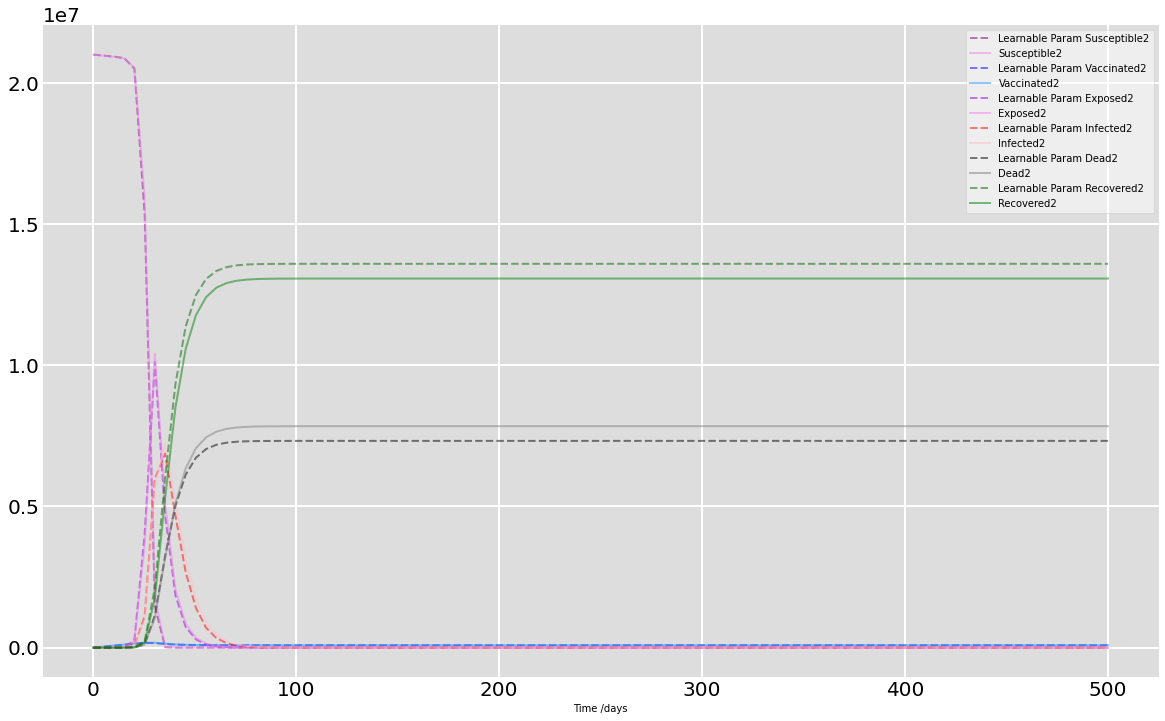

In [26]:
# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w', figsize=(20,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(t, S2, 'purple', alpha=0.5, lw=2, label='Learnable Param Susceptible2', linestyle='dashed')
ax.plot(t, sidr_data[7], 'violet', alpha=0.5, lw=2, label='Susceptible2')

ax.plot(t, V2, 'blue', alpha=0.5, lw=2, label='Learnable Param Vaccinated2', linestyle='dashed')
ax.plot(t, sidr_data[8], 'dodgerblue', alpha=0.5, lw=2, label='Vaccinated2')

ax.plot(t, E2, 'darkviolet', alpha=0.5, lw=2, label='Learnable Param Exposed2', linestyle='dashed')
ax.plot(t, sidr_data[9], 'violet', alpha=0.5, lw=2, label='Exposed2')

ax.plot(t, I2, 'red', alpha=0.5, lw=2, label='Learnable Param Infected2', linestyle='dashed')
ax.plot(t, sidr_data[10], 'pink', alpha=0.5, lw=2, label='Infected2')

ax.plot(t, D2, 'black', alpha=0.5, lw=2, label='Learnable Param Dead2', linestyle='dashed')
ax.plot(t, sidr_data[11], 'grey', alpha=0.5, lw=2, label='Dead2')

ax.plot(t, R2, 'darkgreen', alpha=0.5, lw=2, label='Learnable Param Recovered2', linestyle='dashed')
ax.plot(t, sidr_data[12], 'green', alpha=0.5, lw=2, label='Recovered2')

ax.set_xlabel('Time /days')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.savefig('age_output4_3.png')
plt.show()

In [22]:
#calculate relative MSE loss
import math

S_total_loss = 0
S_den = 0
V_total_loss = 0
V_den = 0
E_total_loss = 0
E_den = 0
I_total_loss = 0
I_den = 0
D_total_loss = 0
D_den = 0
R_total_loss = 0
R_den = 0

for timestep in range(len(t)):
  S_value = sidr_data[1][timestep] - S1[timestep]
  S_total_loss += S_value**2
  S_den += (sidr_data[1][timestep])**2

  V_value = sidr_data[2][timestep] - V1[timestep]
  V_total_loss += V_value**2
  V_den += (sidr_data[2][timestep])**2

  E_value = sidr_data[3][timestep] - E1[timestep]
  E_total_loss += E_value**2
  E_den += (sidr_data[3][timestep])**2

  I_value = sidr_data[4][timestep] - I1[timestep]
  I_total_loss += I_value**2
  I_den += (sidr_data[4][timestep])**2

  D_value = sidr_data[5][timestep] - D1[timestep]
  D_total_loss += D_value**2
  D_den += (sidr_data[5][timestep])**2

  R_value = sidr_data[6][timestep] - R1[timestep]
  R_total_loss += R_value**2
  R_den += (sidr_data[6][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)
V_total_loss = math.sqrt(V_total_loss/V_den)
E_total_loss = math.sqrt(E_total_loss/E_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
D_total_loss = math.sqrt(D_total_loss/D_den)
R_total_loss = math.sqrt(R_total_loss/R_den)

print('S1_total_loss: ', S_total_loss)
print('V1_total_loss: ', V_total_loss)
print('E1_total_loss: ', E_total_loss)
print('I1_total_loss: ', I_total_loss)
print('D1_total_loss: ', D_total_loss)
print('R1_total_loss: ', R_total_loss)

S1_total_loss:  0.01519264860353686
V1_total_loss:  0.034168247196515386
E1_total_loss:  0.0653962996786216
I1_total_loss:  0.07791554075541908
D1_total_loss:  0.06571294202853953
R1_total_loss:  0.04160974991994158


In [23]:
#calculate relative MSE loss
import math

S_total_loss = 0
S_den = 0
V_total_loss = 0
V_den = 0
E_total_loss = 0
E_den = 0
I_total_loss = 0
I_den = 0
D_total_loss = 0
D_den = 0
R_total_loss = 0
R_den = 0

for timestep in range(len(t)):
  S_value = sidr_data[7][timestep] - S2[timestep]
  S_total_loss += S_value**2
  S_den += (sidr_data[7][timestep])**2

  V_value = sidr_data[8][timestep] - V2[timestep]
  V_total_loss += V_value**2
  V_den += (sidr_data[8][timestep])**2

  E_value = sidr_data[9][timestep] - E2[timestep]
  E_total_loss += E_value**2
  E_den += (sidr_data[9][timestep])**2

  I_value = sidr_data[10][timestep] - I2[timestep]
  I_total_loss += I_value**2
  I_den += (sidr_data[10][timestep])**2

  D_value = sidr_data[11][timestep] - D2[timestep]
  D_total_loss += D_value**2
  D_den += (sidr_data[11][timestep])**2

  R_value = sidr_data[12][timestep] - R2[timestep]
  R_total_loss += R_value**2
  R_den += (sidr_data[12][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)
V_total_loss = math.sqrt(V_total_loss/V_den)
E_total_loss = math.sqrt(E_total_loss/E_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
D_total_loss = math.sqrt(D_total_loss/D_den)
R_total_loss = math.sqrt(R_total_loss/R_den)

print('S2_total_loss: ', S_total_loss)
print('V2_total_loss: ', V_total_loss)
print('E2_total_loss: ', E_total_loss)
print('I2_total_loss: ', I_total_loss)
print('D2_total_loss: ', D_total_loss)
print('R2_total_loss: ', R_total_loss)

S2_total_loss:  0.013239525572877747
V2_total_loss:  0.03308050097551767
E2_total_loss:  0.056016092906910876
I2_total_loss:  0.08015641938155038
D2_total_loss:  0.06562095697519492
R2_total_loss:  0.04175345186215371
